## Price Prediction using XGBoost

# Build a model

` Notes`

- ` Using XGBoost `
- ` Explore CrossValidation apart from sklearn.cross_validation eg: xgb.cv and GridSearchCV ` 
- `OneHotEncoding vs LabelEcoder`


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.grid_search import GridSearchCV

import os
# Transforming categorical features for train data
lbl = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder()
#models
import xgboost as xgb

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

% matplotlib inline


C:\Continuum\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Continuum\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from datetime import datetime
from os.path import getmtime

IN_DIR = 'input/'
for filename in os.listdir(IN_DIR):
    print (filename,'\t' ,datetime.fromtimestamp(getmtime(os.path.join(IN_DIR, filename))).strftime('%m/%d/%Y\t%H%M'))

BAD_ADDRESS_FIX.xlsx 	 07/16/2017	2305
data_dictionary.txt 	 07/06/2017	2220
macro.csv 	 07/06/2017	2220
sample_submission.csv 	 04/11/2017	0948
test.csv 	 07/28/2017	2051
test_clean.csv 	 07/28/2017	2052
test_csv.zip 	 07/28/2017	2048
test_fe.csv 	 07/30/2017	2035
train.csv 	 07/28/2017	2052
train_clean.csv 	 07/28/2017	2053
train_csv.zip 	 07/28/2017	2048
train_fe.csv 	 07/30/2017	2035


## Introduction:

That main objective of this notebook it to build a XGBoost Model using train dataset with modified features. The test data is completely untouched as it it reserved for the Kaggle competition evaluation.

Flow of this notebook is as follows:

1. Data preprocessing
2. A basic XGBoost Model for reference
3. Extensive gridsearch cross-validaiton methods to improve the baseline score.


In [3]:
#import feature engineered data

train_df = pd.read_csv("input/train_fe.csv")
test_df = pd.read_csv("input/test_fe.csv")

train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

## 1. Data Preprocessing

In [ ]:
def corr_features():

    excluded_var={
        "young_male", "school_education_centers_top_20_raion", "0_17_female", 
        "railroad_1line", "7_14_female", "0_17_all", "children_school","ecology",
        "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000",
        "7_14_male", "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal",
        "university_top_20_raion", "mosque_count_500","ID_big_road1","ID_railroad_terminal",
        "ID_railroad_station_walk", "ID_big_road2", "ID_metro", "ID_railroad_station_avto",
        "0_13_all", "mosque_count_2000", "work_male", "16_29_all", "young_female", "work_female",
        "0_13_female","ekder_female", "7_14_all", "big_church_count_500","leisure_count_500", 
        "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500", "male_f",
        "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high",
        "market_count_2000", "trc_count_500", "market_count_1000",
        "work_all", "additional_education_raion","build_count_slag", "leisure_count_1000", "0_13_male",
        "office_raion","raion_build_count_with_builddate_info", "market_count_3000", "ekder_all",
        "trc_count_1000", "build_count_1946-1970","office_count_1500", "cafe_count_1500_na_price",
        "big_church_count_5000", "big_church_count_1000", "build_count_foam","church_count_1500",
        "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995", 
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000",
        "big_church_count_1500", "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000",
        "church_count_5000","0_6_all", "detention_facility_raion", "cafe_avg_price_3000","young_male",
        "school_education_centers_top_20_raion", "0_17_female", "railroad_1line", "7_14_female", "0_17_all",
        "children_school","ecology", "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000", "7_14_male", 
        "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal", "university_top_20_raion",
        "mosque_count_500","ID_big_road1","ID_railroad_terminal", "ID_railroad_station_walk", "ID_big_road2",
        "ID_metro", "ID_railroad_station_avto","0_13_all", "mosque_count_2000", "work_male", "16_29_all",
        "young_female", "work_female", "0_13_female","ekder_female", "7_14_all", "big_church_count_500",
        "leisure_count_500", "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500",
        "male_f", "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high","market_count_2000",
        "trc_count_500", "market_count_1000", "work_all", "additional_education_raion",
        "build_count_slag", "leisure_count_1000", "0_13_male", "office_raion","raion_build_count_with_builddate_info",
        "market_count_3000", "ekder_all", "trc_count_1000", "build_count_1946-1970","office_count_1500",
        "cafe_count_1500_na_price", "big_church_count_5000", "big_church_count_1000", "build_count_foam",
        "church_count_1500", "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995",
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000","big_church_count_1500",
        "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000", "church_count_5000","0_6_all",
        "detention_facility_raion", "cafe_avg_price_3000"
    }
    return excluded_var

var_drop = corr_features()

In [ ]:
for var in var_drop:
    train.drop([var],axis=1,inplace=True)
    test.drop([var],axis=1,inplace=True)
    
train.shape, test.shape

In [4]:
# Data preprocessing and creating of test-train split of TRAIN DATA

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        lbl.fit(train_df[col].values)
        train_df[col] = lbl.transform(train_df[col].values)
  #  else:
       # train_df[col] = train_df[col]
        
# Training data test-train set preparation 
train_y = train_df['price_doc']
train_X = train_df.drop(['id', 'timestamp','price_doc'],axis=1)

In [5]:
# Data preprocessing and creating of test-train split of TEST DATA
id_test = test_df['id']
#Preparing test data
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        
        lbl.fit(test_df[col].values)
        test_df[col] = lbl.transform(test_df[col].values)
   # else:
        #test_df[col] = test_df[col]
            
        
test_X = test_df.drop(['id', 'timestamp'], axis=1)

#Show the results 
print("Test data set has {} samples".format(test_X.shape))   

Test data set has (7662, 396) samples


In [6]:
print( train_X.shape, train_y.shape)

(30119, 396) (30119,)


## 2. Basic XGBOOST Model

To begin with, we develop a basic XGBoost Model. The main intention behind this is to get familiar with the parameters and entire training process. 

The XGBoost APIs for training and plotting is mentioned below:
http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train

We use 3-fold cross validation and for 50 trees, if the error has not improved we stop the training early after 10 rounds. The metric used for evaluation is root-mean-square-error.

In [7]:
dtrain = xgb.DMatrix(train_X, train_df['price_doc'])

** Basic list of parameters for the initial setup **


In [8]:

xgb_params_base = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 0,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'min_child_weight': 3
}

The basic model is built by using parametes listed in **xgb_params** and is run for 50 rounds and using XGBoost built in cross validation. The train data is split into three folds and cross validated

In [9]:
xgb_base_cv1 = xgb.cv(xgb_params_base, dtrain, num_boost_round=50, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv1.iloc[-1,:]['test-rmse-mean'])

xgb_base_cv1.describe()

Cross Validation Score: 2300743.41667


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,5.000000e+01,50.000000,5.000000e+01,50.000000
mean,3.051732e+06,22903.817838,2.913831e+06,11546.560580
std,1.224685e+06,9315.735298,1.290327e+06,4032.687016
min,2.300743e+06,14095.291309,2.051494e+06,593.999404
25%,2.333432e+06,15574.899052,2.126301e+06,9605.070231
50%,2.440364e+06,19126.535357,2.290301e+06,11523.609066
75%,3.150803e+06,27774.176691,3.082511e+06,13607.040662
max,7.249912e+06,47576.134618,7.246858e+06,22164.418972


      The crossvalidation score of for the test set 2.300743e+06 can be starting score. Now to scale the tuning, the seeing 
      how train error and test error vary gives a better insight. 

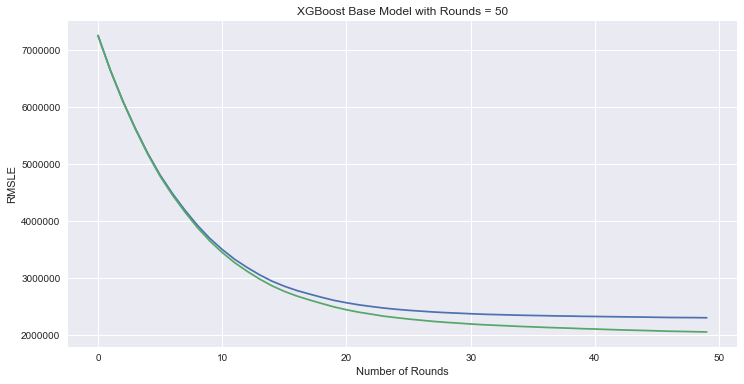

In [10]:
fig,ax =  plt.subplots(figsize= (12,6))

ax.set_title('XGBoost Base Model with Rounds = 50')
ax.plot(xgb_base_cv1[['test-rmse-mean', 'train-rmse-mean']])
ax.set_ylabel('RMSLE')
ax.set_xlabel('Number of Rounds')

plt.show()

Observing the XGBoost curves follwing infernce can be derived:

- Train and test curves are close hence there is not much overfitting
- Error is decreasing, so we can use more iterations.

This encourages us to use more number of rounds for 50 to say, 100.

In [11]:
xgb_base_cv2 = xgb.cv(xgb_params_base, dtrain, num_boost_round=100, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv2.iloc[-1,:]['test-rmse-mean'])

xgb_base_cv2.describe()

Cross Validation Score: 2250772.0


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,2.660826e+06,17723.451841,2.436307e+06,9718.864325
std,9.469955e+05,8439.464429,1.027380e+06,4092.677123
min,2.250772e+06,9513.172613,1.887246e+06,593.999404
25%,2.266469e+06,12941.521619,1.953791e+06,5871.072715
50%,2.300073e+06,14536.240760,2.049201e+06,10129.226212
75%,2.435867e+06,18920.728437,2.284208e+06,12648.221367
max,7.249912e+06,47576.134618,7.246858e+06,22164.418972


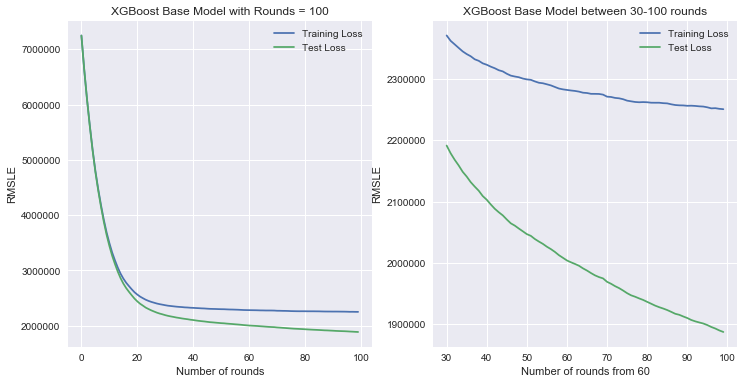

In [12]:
fig,(ax1,ax2) =  plt.subplots(figsize= (12,6), ncols=2)

ax1.set_title('XGBoost Base Model with Rounds = 100')
ax1.plot(xgb_base_cv2[['test-rmse-mean', 'train-rmse-mean']])
ax1.set_ylabel('RMSLE')
ax1.set_xlabel('Number of rounds')
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('XGBoost Base Model between 30-100 rounds')
ax2.plot(xgb_base_cv2.iloc[30:,][['test-rmse-mean', 'train-rmse-mean']])
ax2.set_ylabel('RMSLE')
ax2.set_xlabel('Number of rounds from 60')
ax2.legend(['Training Loss', 'Test Loss'])

plt.show()

On observing the second training data, 

The train-RMSLE is reducing from 2.051494e+06 to 1.887246e+06 whereas test-RMSLE from 2.300743e+06 to 2.250772e+06.

We can clearlysee that the model is getting overfitted as there is very less improvement in the test set. Hence it is better to stop at 50 and improve other important hyper parameters.




# XGBoost parameter tuning 

- max_depth
- min_child_wt
- gammma
- subsample
- col_sample_bytree 

For Trees size
http://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

Other params
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Scorer 

For the evaluation of grid search cross calidation, we define our own scoring function.

https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

In [13]:
def fun_rmse(y_true,dtrain):
    labels = dtrain.get_label()
    rmse = (abs(mean_squared_error(y_true=y_true,y_pred=labels)))**0.5
    return rmse
def rmse_scorer():
    return make_scorer(fun_rmse, greater_is_better=False)    

### Note:

Unfortunaltey, I am unable to get the custom scorer into the GridSearchCV,so I am planning to use sklearn built-in scorer "mean square error" and then calculate square root to get root mean square.

In [14]:
def mse2rmse(score):
    for index,_ in enumerate(score):
        val_sq = (abs(score[index][1]))**0.5
        print ('rmse: {}'.format(val_sq), 'params: {}'.format(score[index][0]))

#### Validate the work-around approach for scoring

In [15]:
xgb_params_cv = {'max_depth': [5], 'min_child_weight': [3]}

xgb_params = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'n_estimators': 50
    
             }


In [16]:
valid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params), param_grid=xgb_params_cv,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [17]:
%%time

valid_xgb.fit(train_X,train_y)

Wall time: 26.9 s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5], 'min_child_weight': [3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [18]:
valid_xgb.grid_scores_

[mean: -5499371607122.68262, std: 609759736836.43799, params: {'max_depth': 5, 'min_child_weight': 3}]

In [20]:
mse2rmse( valid_xgb.grid_scores_)

rmse: 2345073.9022731637 params: {'max_depth': 5, 'min_child_weight': 3}


The value of rmse calculated is close to the rmse value derived from XGBoost "eval-metric"

### Step2: Tuning max_depth and min_child_weight

In [21]:
xgb_params_cv_1 = {'max_depth': list(range(4,10)), 'min_child_weight': list(range(1,7))}

In [23]:
xgb_params_1 = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'n_estimators': 50
             }

In [24]:
optimzed_xgb = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_1), param_grid=xgb_params_cv_1,scoring='mean_squared_error',
                                cv = 5, n_jobs = -1)

In [25]:
%%time
optimzed_xgb.fit(train_X,train_y)

Wall time: 8min 15s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [27]:
(optimzed_xgb.grid_scores_),optimzed_xgb.best_score_,optimzed_xgb.best_params_

([mean: -5668917668922.56055, std: 638644558584.84131, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -5681540930871.74902, std: 655765874112.06860, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -5697557338221.39844, std: 640877542511.36279, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -5664993365417.54199, std: 650668258344.68079, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -5662920435080.75879, std: 633217232808.56616, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -5665418604816.66309, std: 640253326181.61597, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -5500722485365.07129, std: 626311192873.66711, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -5535499309413.44629, std: 618054071587.41919, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -5499371607122.68262, std: 609759736836.43799, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -5490848078881.48535, std: 624410246970.95166, params: {

In [28]:
mse2rmse(optimzed_xgb.grid_scores_)

rmse: 2380948.900947385 params: {'max_depth': 4, 'min_child_weight': 1}
rmse: 2383598.3157553514 params: {'max_depth': 4, 'min_child_weight': 2}
rmse: 2386955.6632290846 params: {'max_depth': 4, 'min_child_weight': 3}
rmse: 2380124.653335943 params: {'max_depth': 4, 'min_child_weight': 4}
rmse: 2379689.1467334046 params: {'max_depth': 4, 'min_child_weight': 5}
rmse: 2380213.982989064 params: {'max_depth': 4, 'min_child_weight': 6}
rmse: 2345361.9092509095 params: {'max_depth': 5, 'min_child_weight': 1}
rmse: 2352764.1848288677 params: {'max_depth': 5, 'min_child_weight': 2}
rmse: 2345073.9022731637 params: {'max_depth': 5, 'min_child_weight': 3}
rmse: 2343255.871406596 params: {'max_depth': 5, 'min_child_weight': 4}
rmse: 2345553.808318123 params: {'max_depth': 5, 'min_child_weight': 5}
rmse: 2343981.6931413845 params: {'max_depth': 5, 'min_child_weight': 6}
rmse: 2338434.756289635 params: {'max_depth': 6, 'min_child_weight': 1}
rmse: 2327120.65118084 params: {'max_depth': 6, 'min_chil

In [29]:
print([{'rmse' : (abs(optimzed_xgb.best_score_)**0.5)}, optimzed_xgb.best_params_])

[{'rmse': 2320553.154218384}, {'max_depth': 7, 'min_child_weight': 1}]


In [30]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [32]:
_, scores_1 = convert_grid_scores(optimzed_xgb.grid_scores_)
scores_1 = scores_1.reshape(6,6)
scores_1 = (abs(scores_1))**0.5

In [33]:
scores_1

array([[2380948.900947385, 2383598.3157553514, 2386955.6632290846,
        2380124.653335943, 2379689.1467334046, 2380213.982989064],
       [2345361.9092509095, 2352764.1848288677, 2345073.9022731637,
        2343255.871406596, 2345553.808318123, 2343981.6931413845],
       [2338434.756289635, 2327120.65118084, 2329446.086394256,
        2336464.391555081, 2326030.7481058165, 2326654.484078736],
       [2320553.154218384, 2321188.4541832563, 2330971.8064343464,
        2322641.5185659146, 2324920.9787055347, 2325322.72686581],
       [2335598.849951298, 2333720.827102487, 2327938.0710834353,
        2335261.014668452, 2337491.582270729, 2327341.987925691],
       [2341596.864006303, 2335644.458366938, 2341360.73542193,
        2335518.5065800296, 2343398.746329527, 2331718.104284062]], dtype=object)

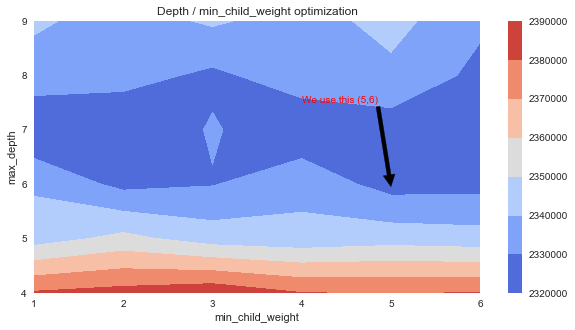

In [34]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_1['min_child_weight'], xgb_params_cv_1['max_depth'], scores_1, cmap='coolwarm')

plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)

plt.annotate('We use this (5,6)', xy=(5., 5.95), xytext=(4, 7.5), arrowprops=dict(facecolor='black'), color='red')


plt.show()

### Step 3: Reducing gamma loss 

https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20662#118487

In [38]:
xgb_params_cv_2 = {'gamma':[ 0.2 * i for i in range(0,6)]}

In [39]:
xgb_params_2 = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'n_estimators': 50
             }

In [40]:
optimzed_xgb_gamma = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_2), param_grid=xgb_params_cv_2,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [41]:
%%time
optimzed_xgb_gamma.fit(train_X, train_y)

Wall time: 1min 43s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [43]:
optimzed_xgb_gamma.grid_scores_,optimzed_xgb_gamma.best_score_, optimzed_xgb_gamma.best_params_

([mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 0.0},
  mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 0.2},
  mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 0.4},
  mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 0.6000000000000001},
  mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 0.8},
  mean: -5384966941552.89062, std: 668896269642.86560, params: {'gamma': 1.0}],
 -5384966941552.891,
 {'gamma': 0.0})

In [44]:
mse2rmse(optimzed_xgb_gamma.grid_scores_)

rmse: 2320553.154218384 params: {'gamma': 0.0}
rmse: 2320553.154218384 params: {'gamma': 0.2}
rmse: 2320553.154218384 params: {'gamma': 0.4}
rmse: 2320553.154218384 params: {'gamma': 0.6000000000000001}
rmse: 2320553.154218384 params: {'gamma': 0.8}
rmse: 2320553.154218384 params: {'gamma': 1.0}


Even after different set of gamma values, the error did no change much. So we will continue to use "gamma" = 0

### Step 4: Tuning subsample and colsample_bytree

In [48]:
xgb_params_cv_3 = {'subsample':[ 0.1 * i for i in range(5,10)],'colsample_bytree':[ 0.1 * i for i in range(5,10)] }

In [49]:
xgb_params_3 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'gamma': 0,
                 'n_estimators': 50
             }

In [50]:
optimzed_xgb_3 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_3), param_grid=xgb_params_cv_3,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [51]:
%%time
optimzed_xgb_3.fit(train_X, train_y)

Wall time: 8min 3s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9], 'colsample_bytree': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [52]:
optimzed_xgb_3.grid_scores_,optimzed_xgb_3.best_params_,optimzed_xgb_3.best_score_

([mean: -5384966941552.89062, std: 668896269642.86560, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: -5381079222930.88574, std: 661880440280.52063, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.5},
  mean: -5359859684050.18164, std: 624560461402.97595, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.5},
  mean: -5287283571896.33789, std: 626161176417.82605, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -5324289417583.62793, std: 615306262977.03320, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -5415330303702.30762, std: 668824897251.57227, params: {'subsample': 0.5, 'colsample_bytree': 0.6000000000000001},
  mean: -5419422594282.60449, std: 689446342291.57532, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -5346585355137.66016, std: 614336490152.45544, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -5293317674591.13184, s

In [53]:
mse2rmse(optimzed_xgb_3.grid_scores_)

rmse: 2320553.154218384 params: {'subsample': 0.5, 'colsample_bytree': 0.5}
rmse: 2319715.332304998 params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.5}
rmse: 2315137.0767300543 params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.5}
rmse: 2299409.3963225293 params: {'subsample': 0.8, 'colsample_bytree': 0.5}
rmse: 2307442.180767186 params: {'subsample': 0.9, 'colsample_bytree': 0.5}
rmse: 2327086.2260995633 params: {'subsample': 0.5, 'colsample_bytree': 0.6000000000000001}
rmse: 2327965.333565473 params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001}
rmse: 2312268.4435717366 params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001}
rmse: 2300721.120560059 params: {'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}
rmse: 2302152.1569052 params: {'subsample': 0.9, 'colsample_bytree': 0.6000000000000001}
rmse: 2326770.4092781683 params: {'subsample': 0.5, 'colsample_bytree': 0.7000000000000001}
rmse: 23170

In [54]:
optimzed_xgb_3.best_score_, optimzed_xgb_3.best_params_

(-5255021938451.134,
 {'colsample_bytree': 0.7000000000000001, 'subsample': 0.9})

In [55]:
print([{'rmse' : (abs(optimzed_xgb_3.best_score_)**0.5)}, optimzed_xgb_3.best_params_])

[{'rmse': 2292383.462348988}, {'subsample': 0.9, 'colsample_bytree': 0.7000000000000001}]


In [56]:
scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

_, scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

scores_3 = scores_3.reshape(5,5)
scores_3 = (abs(scores_3))**0.5

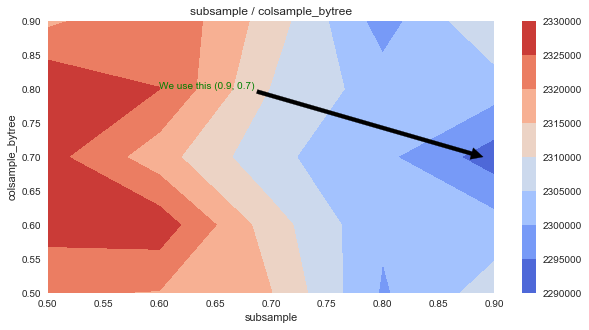

In [60]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_3['subsample'], xgb_params_cv_3['colsample_bytree'], scores_3, cmap='coolwarm')

plt.colorbar(cp)
plt.title('subsample / colsample_bytree')
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)

plt.annotate('We use this (0.9, 0.7)', xy=(0.89,0.7), xytext=(0.6, 0.8), arrowprops=dict(facecolor='black'), color='green')


plt.show()

### Step 5: Reducing Learning rate and add more trees

In [61]:
xgb_params_cv_4 = {'eta':[0.3,0.2,0.1,0.075,0.05,0.04,0.030]}

In [68]:
xgb_params_4 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.7,
                'n_estimators':50
                
                 
             }

In [69]:
optimzed_xgb_4 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_4), param_grid=xgb_params_cv_4,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [70]:
%%time
optimzed_xgb_4.fit(train_X, train_y)

Wall time: 2min 40s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'eta': [0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [71]:
optimzed_xgb_4.grid_scores_,optimzed_xgb_4.best_params_,optimzed_xgb_4.best_score_

([mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.3},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.2},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.1},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.075},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.05},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.04},
  mean: -5255021938451.13379, std: 594586229597.50745, params: {'eta': 0.03}],
 {'eta': 0.3},
 -5255021938451.134)

In [72]:
mse2rmse(optimzed_xgb_4.grid_scores_)

rmse: 2292383.462348988 params: {'eta': 0.3}
rmse: 2292383.462348988 params: {'eta': 0.2}
rmse: 2292383.462348988 params: {'eta': 0.1}
rmse: 2292383.462348988 params: {'eta': 0.075}
rmse: 2292383.462348988 params: {'eta': 0.05}
rmse: 2292383.462348988 params: {'eta': 0.04}
rmse: 2292383.462348988 params: {'eta': 0.03}


#### Eta with 100 rounds

In [73]:
xgb_params_4_1 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.7,
                'n_estimators':100
                
                 
             }

In [74]:
optimzed_xgb_4_1 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_4_1), param_grid=xgb_params_cv_4,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [76]:
%%time
optimzed_xgb_4_1.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'eta': [0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [78]:
optimzed_xgb_4_1.grid_scores_,optimzed_xgb_4_1.best_score_,optimzed_xgb_4_1.best_params_

([mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.3},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.2},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.1},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.075},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.05},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.04},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'eta': 0.03}],
 -5189293646119.542,
 {'eta': 0.3})

In [79]:
mse2rmse(optimzed_xgb_4_1.grid_scores_)

rmse: 2278002.117233332 params: {'eta': 0.3}
rmse: 2278002.117233332 params: {'eta': 0.2}
rmse: 2278002.117233332 params: {'eta': 0.1}
rmse: 2278002.117233332 params: {'eta': 0.075}
rmse: 2278002.117233332 params: {'eta': 0.05}
rmse: 2278002.117233332 params: {'eta': 0.04}
rmse: 2278002.117233332 params: {'eta': 0.03}


### Step 5: n_estimators

In [81]:
xgb_params_cv_5 = {'n_estimators':[50,100,150,200,250]}

In [82]:
xgb_params_5 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.7                
                 
             }

In [83]:
optimzed_xgb_5 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_5), param_grid=xgb_params_cv_5,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [84]:
%%time
optimzed_xgb_5.fit(train_X, train_y)

Wall time: 5min 34s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [85]:
optimzed_xgb_5.grid_scores_,optimzed_xgb_5.best_score_,optimzed_xgb_5.best_params_

([mean: -5255021938451.13379, std: 594586229597.50745, params: {'n_estimators': 50},
  mean: -5189293646119.54199, std: 610436657814.94629, params: {'n_estimators': 100},
  mean: -5213382831809.10840, std: 625385442546.83411, params: {'n_estimators': 150},
  mean: -5224930086564.35645, std: 623683701624.22668, params: {'n_estimators': 200},
  mean: -5243897892562.45703, std: 629044574289.43115, params: {'n_estimators': 250}],
 -5189293646119.542,
 {'n_estimators': 100})

In [86]:
mse2rmse(optimzed_xgb_5.grid_scores_)

rmse: 2292383.462348988 params: {'n_estimators': 50}
rmse: 2278002.117233332 params: {'n_estimators': 100}
rmse: 2283283.3446178134 params: {'n_estimators': 150}
rmse: 2285810.5972639895 params: {'n_estimators': 200}
rmse: 2289955.871313344 params: {'n_estimators': 250}


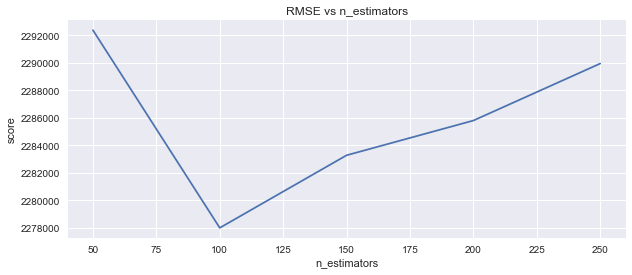

In [93]:
eta = [50,100,150,200,250]
_, loss = convert_grid_scores(optimzed_xgb_5.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('RMSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.plot(eta, (abs(loss)**0.5))
plt.grid(True)
plt.show()

### The Best Model

In [95]:
xgb_params_best = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 7,
                 'min_child_weight':1,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.7,
                 'n_estimators': 100
                 
             }

In [96]:
xgb_best = xgb.cv(xgb_params_best, dtrain, num_boost_round=100, nfold=5, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

In [97]:
print('Cross Validation Score:' ,xgb_base_cv2.iloc[-1,:]['test-rmse-mean'])

xgb_best.describe()

Cross Validation Score: 2250772.0


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,2.599467e+06,36112.644737,2.075001e+06,13958.612888
std,9.477766e+05,3531.368354,1.128717e+06,3843.758622
min,2.214518e+06,31118.761170,1.429418e+06,6041.323797
25%,2.221688e+06,33386.637771,1.518544e+06,11189.349032
50%,2.240409e+06,35483.396963,1.645440e+06,13250.938468
75%,2.352820e+06,37828.586719,1.953926e+06,16778.163865
max,7.261323e+06,48321.417399,7.250391e+06,22067.850479
